In [1]:
import os
import sys
from pathlib import Path

import torch
import networkx as nx
import sys, os

ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(ROOT, "src"))

from dagc.data.graph_loading import load_graphs_from_dir, graph_to_tensors
from dagc.sparsifiers.gnn.train import load_gnn_sparsifier


In [2]:
ckpt_path = "results/checkpoints/gnn_rw_k1_keep0.8_num_steps_1.pt"
model = load_gnn_sparsifier(ckpt_path, device="cpu")

[load] Loaded GNNSparsifier from results/checkpoints/gnn_rw_k1_keep0.8_num_steps_1.pt on device cpu


In [3]:
from pathlib import Path

# Project root = parent of current working dir (or adjust as needed)
ROOT = Path.cwd().parent

split = "test" 

graph_dir = ROOT / "data" / "synthetic_graphs" / "ba" / split
print("Graph dir:", graph_dir)

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:10]
print("Loaded", len(graphs_10), "graphs for evaluation")


Graph dir: /Users/nicholaskhorasani/Documents/CodingProjects/diffusion-aware-graph-compression/data/synthetic_graphs/ba/test
Loaded 10 graphs for evaluation


In [4]:
from dagc.metrics.collect_metrics import evaluate_one_graph

In [5]:
ckpt_path = "results/checkpoints/gnn_rw_k1_keep0.8_num_steps_1.pt"
model = load_gnn_sparsifier(ckpt_path, device="cpu")

from pathlib import Path

# Project root = parent of current working dir (or adjust as needed)
ROOT = Path.cwd().parent

split = "test" 

graph_dir = ROOT / "data" / "synthetic_graphs" / "ba" / split
print("Graph dir:", graph_dir)

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:10]
print("Loaded", len(graphs_10), "graphs for evaluation")

[load] Loaded GNNSparsifier from results/checkpoints/gnn_rw_k1_keep0.8_num_steps_1.pt on device cpu
Graph dir: /Users/nicholaskhorasani/Documents/CodingProjects/diffusion-aware-graph-compression/data/synthetic_graphs/ba/test
Loaded 10 graphs for evaluation


In [6]:
keep_ratio = 0.7
seed_set_size = 10
activation_prob = 0.1
num_runs = 400

all_rand = []
all_gnn = []
all_eff = []

for idx, G in enumerate(graphs_10):
    print(f"\n================  Graph {idx}  ================")
    print(f"|V| = {G.number_of_nodes()}, |E| = {G.number_of_edges()}")

    (
        metrics_rand,
        metrics_gnn,
        metrics_eff,
        orig_summary,
        rand_summary,
        gnn_summary,
        eff_summary,
        H_rand,
        H_gnn,
        H_eff,
    ) = evaluate_one_graph(
        G=G,
        model=model,
        keep_ratio=keep_ratio,
        seed_set_size=seed_set_size,
        activation_prob=activation_prob,
        num_runs=num_runs,
        base_seed=12345 + idx * 10000,  # different seed per graph
        device="cpu",
    )

    all_rand.append(metrics_rand)
    all_gnn.append(metrics_gnn)
    all_eff.append(metrics_eff)

    # Edge counts
    print(f"|E_rand| = {H_rand.number_of_edges()} (random sparsifier)")
    print(f"|E_gnn|  = {H_gnn.number_of_edges()} (GNN sparsifier)")
    print(f"|E_eff|  = {H_eff.number_of_edges()} (ER sparsifier)")

    # Raw expected spreads
    orig_spread = orig_summary.expected_spread
    rand_spread = rand_summary.expected_spread
    gnn_spread = gnn_summary.expected_spread
    eff_spread = eff_summary.expected_spread

    print("\nRaw expected spreads:")
    print(f"  Original:       {orig_spread:.3f}")
    print(f"  Random sparse:  {rand_spread:.3f}")
    print(f"  GNN sparse:     {gnn_spread:.3f}")
    print(f"  ER sparse:      {eff_spread:.3f}")

    # Simple diffusion-preservation metrics
    print("\nRandom sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_rand['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_rand['prob_mse']:.6f}")

    print("\nGNN sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_gnn['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_gnn['prob_mse']:.6f}")

    print("\nEffective-resistance sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_eff['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_eff['prob_mse']:.6f}")



================  Graph 0  ================
|V| = 1000, |E| = 2991
Shifting edge scores by 0.0000 to ensure non-negativity.
|E_rand| = 2094 (random sparsifier)
|E_gnn|  = 2093 (GNN sparsifier)
|E_eff|  = 2094 (ER sparsifier)

Raw expected spreads:
  Original:       130.312
  Random sparse:  75.420
  GNN sparse:     111.780
  ER sparse:      151.252

Random sparsifier vs original:
  spread_abs_diff:  54.892
  prob_mse:         0.005331

GNN sparsifier vs original:
  spread_abs_diff:  18.532
  prob_mse:         0.000992

Effective-resistance sparsifier vs original:
  spread_abs_diff:  20.940
  prob_mse:         0.008649

================  Graph 1  ================
|V| = 1000, |E| = 2991
Shifting edge scores by 0.0000 to ensure non-negativity.
|E_rand| = 2094 (random sparsifier)
|E_gnn|  = 2093 (GNN sparsifier)
|E_eff|  = 2094 (ER sparsifier)

Raw expected spreads:
  Original:       133.150
  Random sparse:  77.808
  GNN sparse:     112.780
  ER sparse:      150.305

Random sparsifier vs

In [7]:
import pandas as pd

rows = []

for idx, (m_r, m_g, m_e) in enumerate(zip(all_rand, all_gnn, all_eff)):
    rows.append({
        "graph_idx": idx,
        "method": "random",
        "spread_abs_diff": m_r["spread_abs_diff"],
        "prob_mse": m_r["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "gnn",
        "spread_abs_diff": m_g["spread_abs_diff"],
        "prob_mse": m_g["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "er",
        "spread_abs_diff": m_e["spread_abs_diff"],
        "prob_mse": m_e["prob_mse"],
    })

df = pd.DataFrame(rows)
print(df.head())


   graph_idx  method  spread_abs_diff  prob_mse
0          0  random          54.8925  0.005331
1          0     gnn          18.5325  0.000992
2          0      er          20.9400  0.008649
3          1  random          55.3425  0.005495
4          1     gnn          20.3700  0.001088


In [8]:

summary = df.groupby("method").agg(
    mean_spread_abs_diff=("spread_abs_diff", "mean"),
    std_spread_abs_diff=("spread_abs_diff", "std"),
    mean_prob_mse=("prob_mse", "mean"),
    std_prob_mse=("prob_mse", "std"),
).reset_index()

print(summary)

   method  mean_spread_abs_diff  std_spread_abs_diff  mean_prob_mse  \
0      er               20.8355             5.292556       0.007878   
1     gnn               18.3650             1.330011       0.000940   
2  random               53.7300             1.648821       0.005178   

   std_prob_mse  
0      0.000767  
1      0.000077  
2      0.000278  


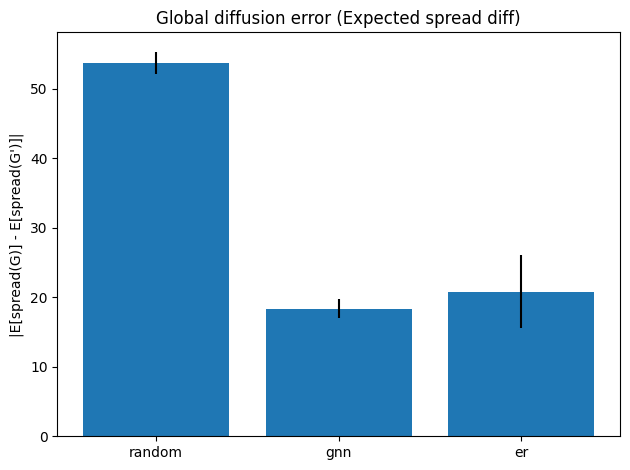

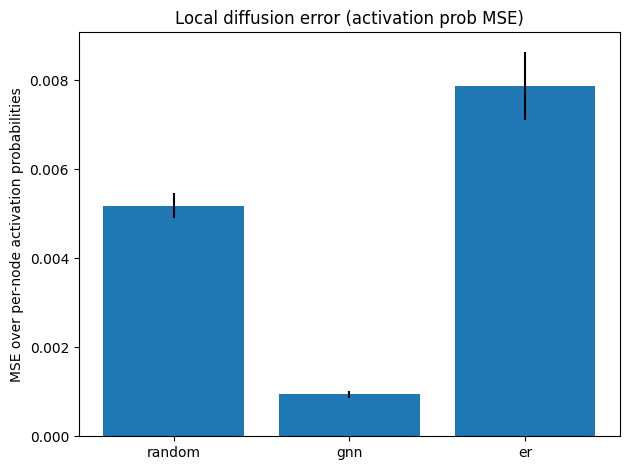

In [9]:
import matplotlib.pyplot as plt

methods = ["random", "gnn", "er"]

# Spread diff
plt.figure()
means = [summary.loc[summary.method == m, "mean_spread_abs_diff"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_spread_abs_diff"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("|E[spread(G)] - E[spread(G')]|")
plt.title("Global diffusion error (Expected spread diff)")
plt.tight_layout()
plt.show()

# Prob MSE
plt.figure()
means = [summary.loc[summary.method == m, "mean_prob_mse"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_prob_mse"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("MSE over per-node activation probabilities")
plt.title("Local diffusion error (activation prob MSE)")
plt.tight_layout()
plt.show()


